In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

In [3]:
import torch
from torch.nn.functional import grid_sample
from deepshape.curves import *

In [4]:
from scipy.ndimage import gaussian_filter1d

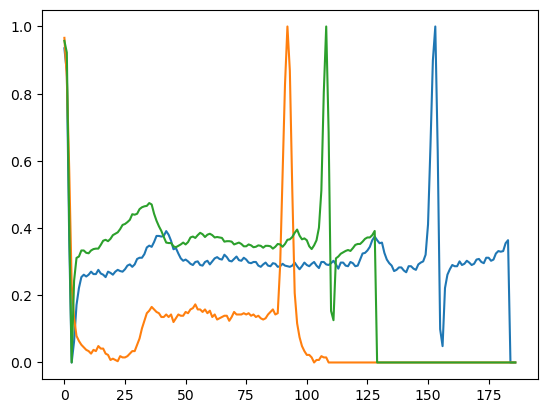

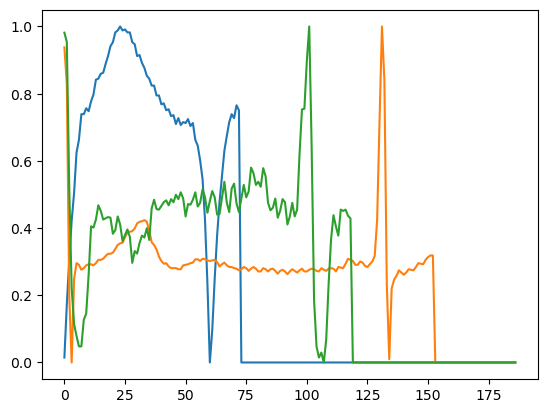

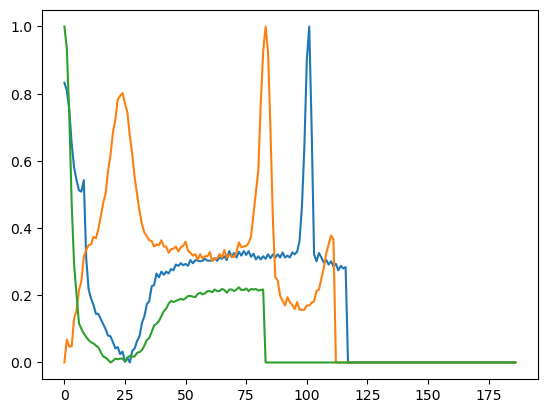

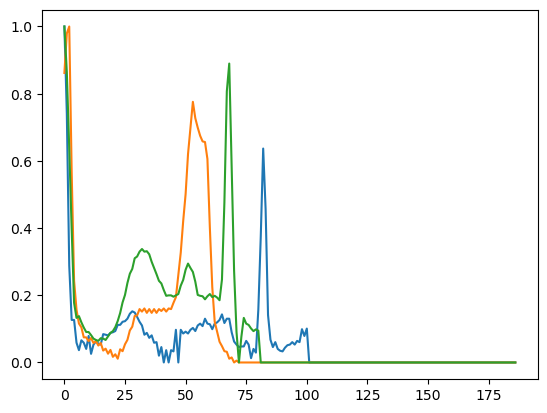

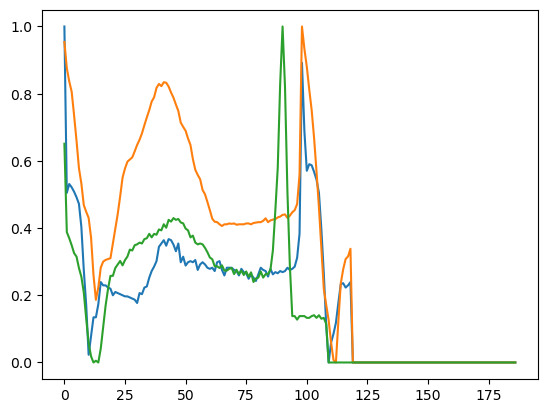

In [5]:
datapath = '../data/mitbih_train.csv'

df = pd.read_csv(datapath, header=None)
df, labels = df.iloc[:, :-1], df.iloc[:, -1].astype(int)

for i in np.unique(labels):
    plt.figure()
    plt.plot(df.where(labels == i).dropna().sample(3).transpose())
    
plt.show()

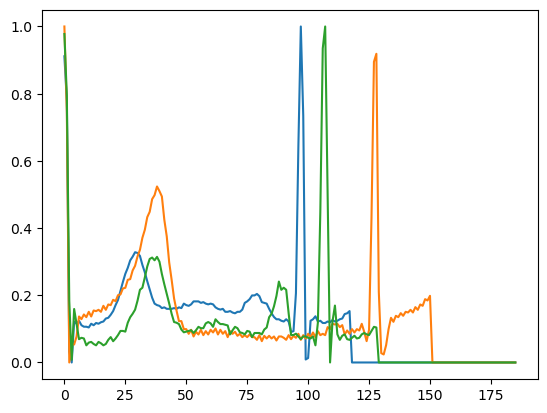

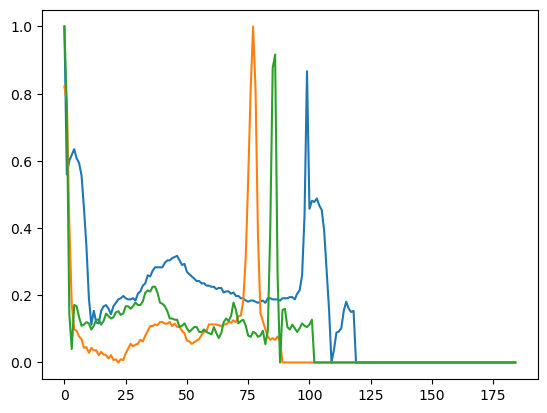

In [6]:
datapath = '../data/ptbdb_normal.csv'
dfn = pd.read_csv(datapath, header=None)
df, labels = df.iloc[:, :-1], df.iloc[:, -1].astype(int)
plt.plot(df.sample(3).transpose())
plt.show()

datapath = '../data/ptbdb_abnormal.csv'
dfabn = pd.read_csv(datapath, header=None)
df, labels = df.iloc[:, :-1], df.iloc[:, -1].astype(int)
plt.plot(df.sample(3).transpose())
plt.show()

In [7]:
class FuncApprox:
    def __init__(self, data):
        self.data = torch.zeros(1, 1, 1, data.shape[0])
        self.data[0, 0, 0, :] = data.squeeze()
        
    def __call__(self, x):
        grid = torch.zeros(1, 1, x.shape[0], 2)
        grid[0, 0, :, 0] = 2. * x.squeeze() - 1.
        return grid_sample(self.data, grid, padding_mode='border', align_corners=False, mode='bicubic').reshape(-1, 1)
    
    def _create_grid(self, x):
        if self.grid.shape[2] != x.view(-1).shape[0]:
            self.grid = torch.zeros(1, 1, x.shape[0], 2)
        self.grid[0, 0, :, 0] = 2. * x.squeeze() - 1.
        return self.grid
    
class FourierApprox:
    def __init__(self, y: torch.Tensor, N: int):
        Xtr = col_linspace(0, 1, y.view(-1).shape[0])
        self.N = N
        self.dim = 1 + 2*N
        self.freqvec = torch.arange(1, N+1) * 2.0 * pi
        self.find_weights(Xtr, y)

    def eval_basis(self, x):
        T = self.freqvec * x
        B = torch.cat([torch.ones_like(x), sin(T), cos(T)], dim=1)
        return B

    def __call__(self, x):
        B = self.eval_basis(x)
        return torch.mm(B, self.w)

    def find_weights(self, x, y):
        B = self.eval_basis(x)
        w = np.linalg.solve(torch.mm(B.t(), B).numpy(),
                            torch.mm(B.t(), y).numpy())
        self.w = torch.Tensor(w)

class FunctionalQmap:
    def __init__(self, f: FuncApprox):
        self.f = f
        
    def __call__(self, x, h=1e-4):
        Df = central_differences(self.f, x, h)
        return torch.sqrt(torch.abs(Df)+1e-8) * self.f(x)
#         return torch.sign(Df) * torch.sqrt(torch.abs(Df)+1e-8)
#         return torch.sign(Df) * torch.sqrt(torch.abs(Df) + 1e-8) * self.f(x)

def get_ecg_curve(df, idx, sigma=1.5, remove_trailing_zeros=True):
    y = torch.tensor(df.iloc[idx], dtype=torch.float32)
    if remove_trailing_zeros:
        y = y[torch.nonzero(y, as_tuple=False)]
    y = gaussian_filter1d(y.squeeze(), sigma=sigma)
    return torch.tensor(y).reshape(-1, 1)

[Iter     1] loss: 0.128653
[Iter     6] loss: 0.051403
[Iter    11] loss: 0.040743
[Iter    16] loss: 0.040673
[Iter    21] loss: 0.041099
[Iter    26] loss: 0.039966
[Iter    31] loss: 0.039835
[Iter    36] loss: 0.039705
[Iter    41] loss: 0.039664

Finished training in 1.70936s


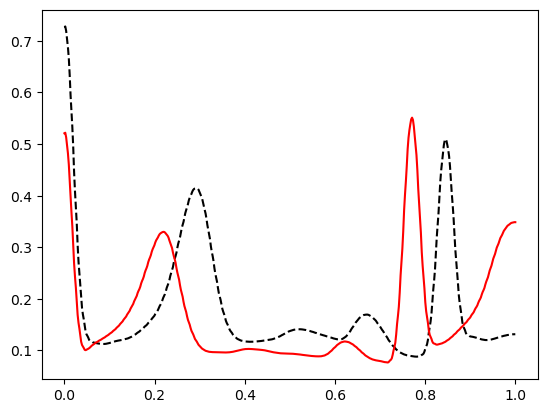

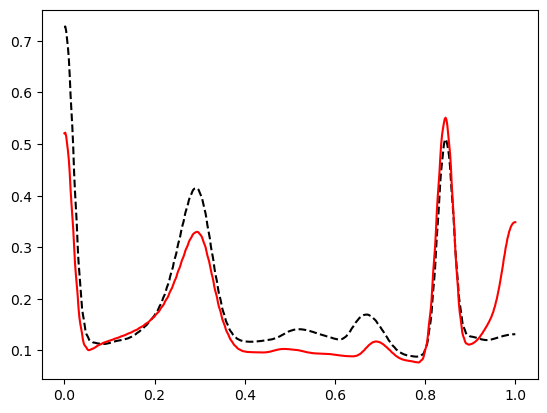

In [8]:
def reparametrize_and_plot(g1, g2):
    q = FunctionalQmap(g1)
    r = FunctionalQmap(g2)
    loss = CurveDistance(q, r, 512)

    RN = CurveReparametrizer([
        SineSeries(10) for _ in range(10)
    ])

    optimizer = torch.optim.LBFGS(RN.parameters(), max_iter=100, line_search_fn='strong_wolfe')
    log = Logger(5)

    error = reparametrize(RN, loss, optimizer, 200, log)
    
    x = col_linspace(0, 1, 512)
    with torch.no_grad():
        
        plt.figure()
        plt.plot(x, g1(x), '--', c='k')
        plt.plot(x, g2(x),  c='r')
        
        plt.figure()
        plt.plot(x, g1(x), ls='--', c='k')
#         plt.plot(x, f1(RN(x)), c='r')

        plt.plot(x, g2(RN(x)), c='r')

        
d1 = get_ecg_curve(dfn, 0, sigma=2.0, remove_trailing_zeros=True)
f1 = FuncApprox(d1)

d2 = get_ecg_curve(dfn, 5, sigma=2.0, remove_trailing_zeros=True)
f2 = FuncApprox(d2)
reparametrize_and_plot(f1, f2)
plt.show()

[Iter     1] loss: 0.209856
[Iter     6] loss: 0.081675
[Iter    11] loss: 0.071235
[Iter    16] loss: 0.067234
[Iter    21] loss: 0.060620
[Iter    26] loss: 0.058949
[Iter    31] loss: 0.058757
[Iter    36] loss: 0.058496
[Iter    41] loss: 0.058272
[Iter    46] loss: 0.058203
[Iter    51] loss: 0.057942
[Iter    56] loss: 0.057810
[Iter    61] loss: 0.057795
[Iter    66] loss: 0.057788
[Iter    71] loss: 0.057781
[Iter    76] loss: 0.057765

Finished training in 0.68553s


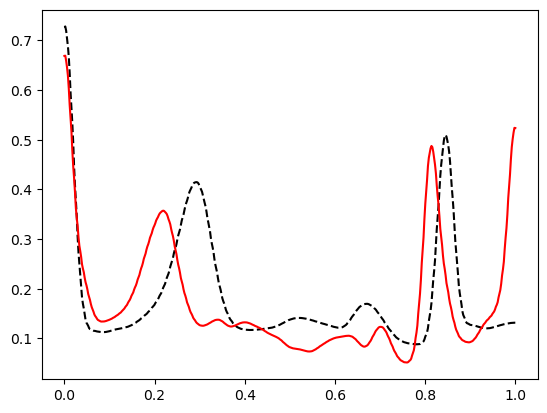

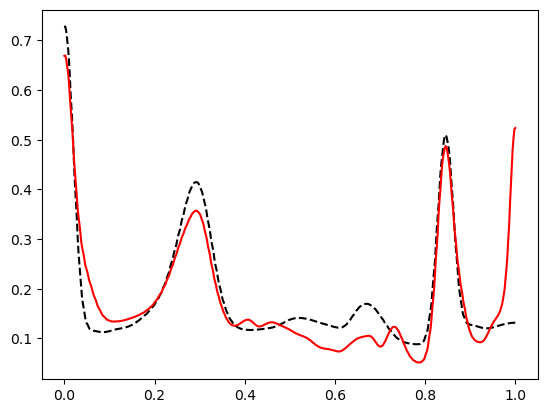

In [9]:
d1 = get_ecg_curve(dfn, 0, sigma=2.0, remove_trailing_zeros=True)
f1 = FuncApprox(d1)

d2 = get_ecg_curve(dfabn, 1, sigma=2.0, remove_trailing_zeros=True)
f2 = FuncApprox(d2)
reparametrize_and_plot(f1, f2)
plt.show()